**Lab M1.03 - sklearn Model Training + Evaluation**

Breast Churn Prediction with KNN

Dina Bosma-Buczynska

**Part 2: Unguided Exercise - Customer Churn Prediction**

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            confusion_matrix, classification_report)

# STEP 1: LOAD THE DATA
print("="*60)
print("LOADING TELCO CUSTOMER CHURN DATASET")
print("="*60)

# Load from local file (if you downloaded it)
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

print(f"Dataset shape: {df.shape}")
print(f"Number of customers: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

print("\nFirst few rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nColumn names:")
print(df.columns.tolist())

print("\nMissing values:")
print(df.isnull().sum())

print("\nTarget distribution (Churn):")
print(df['Churn'].value_counts())

LOADING TELCO CUSTOMER CHURN DATASET
Dataset shape: (7043, 21)
Number of customers: 7043
Number of features: 21

First few rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4         

**Step 2: Data Preprocessing**

In [5]:
# STEP 2: DATA PREPROCESSING

print("\n" + "="*60)
print("DATA PREPROCESSING")
print("="*60)

# HANDLE MISSING VALUES
print("\nChecking for missing values...")

# Check for non-numeric values in numeric columns
# TotalCharges sometimes has spaces instead of numbers
if 'TotalCharges' in df.columns:
    # Convert TotalCharges to numeric (spaces become NaN)
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    print(f"Converted TotalCharges to numeric")

missing = df.isnull().sum()
if missing.sum() > 0:
    print("Columns with missing values:")
    print(missing[missing > 0])
    # Drop rows with missing values
    df = df.dropna()
    print(f"\nDropped rows with missing values. New shape: {df.shape}")
else:
    print("✓ No missing values!")

# REMOVE CUSTOMER ID (Is not useful for prediction)
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)
    print("\n✓ Removed customerID column")

# CONVERT TARGET VARIABLE TO BINARY (0/1)
print("\nConverting target variable...")
if df['Churn'].dtype == 'object':  # If it is text
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
    print("✓ Converted Churn: Yes→1, No→0")

print(f"\nChurn distribution after conversion:")
print(df['Churn'].value_counts())
print(f"  Retained (0): {(df['Churn']==0).sum()} ({(df['Churn']==0).mean()*100:.1f}%)")
print(f"  Churned (1):  {(df['Churn']==1).sum()} ({(df['Churn']==1).mean()*100:.1f}%)")

# IDENTIFY CATEGORICAL AND NUMERIC COLUMNS
print("\nIdentifying categorical and numeric columns...")
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numeric columns ({len(numeric_cols)}): {numeric_cols}")

# ENCODE CATEGORICAL VARIABLES

# For binary categorical (Yes/No, Male/Female, etc.)
print("\nEncoding binary categorical variables...")
binary_cols = []
for col in categorical_cols:
    if df[col].nunique() == 2:  # Only 2 unique values
        binary_cols.append(col)
        unique_vals = df[col].unique()
        # Map to 0 and 1
        mapping = {unique_vals[0]: 0, unique_vals[1]: 1}
        df[col] = df[col].map(mapping)
        print(f"  {col}: {unique_vals[0]}→0, {unique_vals[1]}→1")

# For non-binary categorical 
non_binary_cols = [col for col in categorical_cols if col not in binary_cols]
if len(non_binary_cols) > 0:
    print(f"\nApplying one-hot encoding to: {non_binary_cols}")
    df = pd.get_dummies(df, columns=non_binary_cols, drop_first=True)
    print("✓ One-hot encoding complete!")

print("\n✓ Data preprocessing complete!")
print(f"Final dataset shape: {df.shape}")
print(f"\nFirst few rows after preprocessing:")
print(df.head())


DATA PREPROCESSING

Checking for missing values...
Converted TotalCharges to numeric
✓ No missing values!

Converting target variable...

Churn distribution after conversion:
Churn
0    5163
1    1869
Name: count, dtype: int64
  Retained (0): 5163 (73.4%)
  Churned (1):  1869 (26.6%)

Identifying categorical and numeric columns...

Categorical columns (0): []
Numeric columns (10): ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn']

Encoding binary categorical variables...

✓ Data preprocessing complete!
Final dataset shape: (7032, 31)

First few rows after preprocessing:
   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        0           0       1             0   
1       1              0        1           0      34             1   
2       1              0        1           0       2             1   
3       1              0        1           0 

**ADDED SECTION FOR FEATURE EXPLANATION**

In [ ]:
# ==========================================================
# FEATURE EXPLORATION - Understanding what causes churn
# ==========================================================

print("\n" + "="*60)
print("EXPLORING FEATURES - WHAT CAUSES CHURN?")
print("="*60)

# First, let's reload the original data to see categorical values
# (because we already converted everything to numbers)
print("\nReloading original data to analyze categorical features...")
df_original = pd.read_csv('https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv')

# Convert TotalCharges to numeric
df_original['TotalCharges'] = pd.to_numeric(df_original['TotalCharges'], errors='coerce')
df_original = df_original.dropna()

# Convert Churn to binary for calculations
df_original['Churn_Binary'] = df_original['Churn'].map({'Yes': 1, 'No': 0})

# -------------------------
# 1. CHURN BY CONTRACT TYPE
# -------------------------
print("\n" + "-"*60)
print("1. CHURN RATE BY CONTRACT TYPE")
print("-"*60)

contract_churn = df_original.groupby('Contract')['Churn_Binary'].agg(['sum', 'count', 'mean'])
contract_churn.columns = ['Churned', 'Total', 'Churn_Rate']
contract_churn['Churn_Rate_Percent'] = contract_churn['Churn_Rate'] * 100

print(contract_churn)
print("\nInterpretation:")
for contract_type in contract_churn.index:
    rate = contract_churn.loc[contract_type, 'Churn_Rate_Percent']
    total = contract_churn.loc[contract_type, 'Total']
    churned = contract_churn.loc[contract_type, 'Churned']
    print(f"  • {contract_type}: {churned:.0f} out of {total:.0f} customers churned ({rate:.1f}%)")

# -------------------------
# 2. CHURN BY INTERNET SERVICE
# -------------------------
print("\n" + "-"*60)
print("2. CHURN RATE BY INTERNET SERVICE TYPE")
print("-"*60)

internet_churn = df_original.groupby('InternetService')['Churn_Binary'].agg(['sum', 'count', 'mean'])
internet_churn.columns = ['Churned', 'Total', 'Churn_Rate']
internet_churn['Churn_Rate_Percent'] = internet_churn['Churn_Rate'] * 100

print(internet_churn)
print("\nInterpretation:")
for service_type in internet_churn.index:
    rate = internet_churn.loc[service_type, 'Churn_Rate_Percent']
    total = internet_churn.loc[service_type, 'Total']
    churned = internet_churn.loc[service_type, 'Churned']
    print(f"  • {service_type}: {churned:.0f} out of {total:.0f} customers churned ({rate:.1f}%)")

# -------------------------
# 3. MONTHLY CHARGES COMPARISON
# -------------------------
print("\n" + "-"*60)
print("3. MONTHLY CHARGES - CHURNED VS RETAINED")
print("-"*60)

churned_charges = df_original[df_original['Churn'] == 'Yes']['MonthlyCharges']
retained_charges = df_original[df_original['Churn'] == 'No']['MonthlyCharges']

print(f"Average Monthly Charges:")
print(f"  • Churned customers:  ${churned_charges.mean():.2f}")
print(f"  • Retained customers: ${retained_charges.mean():.2f}")
print(f"  • Difference: ${churned_charges.mean() - retained_charges.mean():.2f} higher for churned customers")

# -------------------------
# 4. TENURE COMPARISON
# -------------------------
print("\n" + "-"*60)
print("4. TENURE (HOW LONG THEY'VE BEEN CUSTOMERS)")
print("-"*60)

churned_tenure = df_original[df_original['Churn'] == 'Yes']['tenure']
retained_tenure = df_original[df_original['Churn'] == 'No']['tenure']

print(f"Average Tenure (months):")
print(f"  • Churned customers:  {churned_tenure.mean():.1f} months")
print(f"  • Retained customers: {retained_tenure.mean():.1f} months")
print(f"  • Difference: {retained_tenure.mean() - churned_tenure.mean():.1f} months longer for retained customers")

# -------------------------
# 5. PAYMENT METHOD
# -------------------------
print("\n" + "-"*60)
print("5. CHURN RATE BY PAYMENT METHOD")
print("-"*60)

payment_churn = df_original.groupby('PaymentMethod')['Churn_Binary'].agg(['sum', 'count', 'mean'])
payment_churn.columns = ['Churned', 'Total', 'Churn_Rate']
payment_churn['Churn_Rate_Percent'] = payment_churn['Churn_Rate'] * 100
payment_churn = payment_churn.sort_values('Churn_Rate_Percent', ascending=False)

print(payment_churn)
print("\nInterpretation:")
for payment_type in payment_churn.index:
    rate = payment_churn.loc[payment_type, 'Churn_Rate_Percent']
    print(f"  • {payment_type}: {rate:.1f}% churn rate")

# -------------------------
# 6. TECH SUPPORT
# -------------------------
print("\n" + "-"*60)
print("6. CHURN RATE BY TECH SUPPORT")
print("-"*60)

tech_churn = df_original.groupby('TechSupport')['Churn_Binary'].agg(['sum', 'count', 'mean'])
tech_churn.columns = ['Churned', 'Total', 'Churn_Rate']
tech_churn['Churn_Rate_Percent'] = tech_churn['Churn_Rate'] * 100

print(tech_churn)
print("\nInterpretation:")
for tech_type in tech_churn.index:
    rate = tech_churn.loc[tech_type, 'Churn_Rate_Percent']
    print(f"  • {tech_type}: {rate:.1f}% churn rate")

# -------------------------
# SUMMARY OF KEY FINDINGS
# -------------------------
print("\n" + "="*60)
print("KEY FINDINGS SUMMARY")
print("="*60)

print("\nHighest Risk Customers (Most Likely to Churn):")
print(f"  1. Contract Type: Month-to-month customers churn at {contract_churn.loc['Month-to-month', 'Churn_Rate_Percent']:.1f}%")
print(f"  2. Internet Service: Fiber optic customers churn at {internet_churn.loc['Fiber optic', 'Churn_Rate_Percent']:.1f}%")
print(f"  3. Monthly Charges: Churned customers pay ${churned_charges.mean():.2f} vs ${retained_charges.mean():.2f} for retained")
print(f"  4. Tenure: Churned customers have been with company {churned_tenure.mean():.1f} months (newer customers)")
print(f"  5. Tech Support: Customers without tech support churn more")

print("\nLowest Risk Customers (Least Likely to Churn):")
print(f"  1. Contract Type: Two-year contracts churn at {contract_churn.loc['Two year', 'Churn_Rate_Percent']:.1f}%")
print(f"  2. Tenure: Retained customers have been with company {retained_tenure.mean():.1f} months (longer)")
print(f"  3. Tech Support: Customers with tech support have lower churn")




EXPLORING FEATURES - WHAT CAUSES CHURN?

Reloading original data to analyze categorical features...

------------------------------------------------------------
1. CHURN RATE BY CONTRACT TYPE
------------------------------------------------------------
                Churned  Total  Churn_Rate  Churn_Rate_Percent
Contract                                                      
Month-to-month     1655   3875    0.427097           42.709677
One year            166   1472    0.112772           11.277174
Two year             48   1685    0.028487            2.848665

Interpretation:
  • Month-to-month: 1655 out of 3875 customers churned (42.7%)
  • One year: 166 out of 1472 customers churned (11.3%)
  • Two year: 48 out of 1685 customers churned (2.8%)

------------------------------------------------------------
2. CHURN RATE BY INTERNET SERVICE TYPE
------------------------------------------------------------
                 Churned  Total  Churn_Rate  Churn_Rate_Percent
InternetServic

**Step 3: Split the Data**

In [6]:
# STEP 3: SPLIT THE DATA

print("\n" + "="*60)
print("SPLITTING DATA")
print("="*60)

# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTraining set:")
print(f"  Size: {X_train.shape[0]} samples")
print(f"  Features: {X_train.shape[1]}")
print(f"  Churned: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")
print(f"  Retained: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")

print("\nTest set:")
print(f"  Size: {X_test.shape[0]} samples")
print(f"  Features: {X_test.shape[1]}")
print(f"  Churned: {(y_test == 1).sum()} ({(y_test == 1).mean()*100:.1f}%)")
print(f"  Retained: {(y_test == 0).sum()} ({(y_test == 0).mean()*100:.1f}%)")


SPLITTING DATA
Features shape: (7032, 30)
Target shape: (7032,)

Training set:
  Size: 5625 samples
  Features: 30
  Churned: 1495 (26.6%)
  Retained: 4130 (73.4%)

Test set:
  Size: 1407 samples
  Features: 30
  Churned: 374 (26.6%)
  Retained: 1033 (73.4%)


**Step 4: Train a KNN Model**

In [7]:
# STEP 4: TRAIN KNN MODEL

print("\n" + "="*60)
print("TRAINING KNN MODEL")
print("="*60)

# Create and train KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

print("✓ KNN model trained successfully!")
print(f"K value: {knn.n_neighbors}")

# Make predictions
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

print(f"Predictions made on {len(y_test_pred)} test samples")


TRAINING KNN MODEL
✓ KNN model trained successfully!
K value: 5
Predictions made on 1407 test samples


**Step 5: Make Predictions and Evaluate**

In [10]:
# STEP 5: EVALUATE MODEL

print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_confusion = confusion_matrix(y_test, y_test_pred)

print("\n=== ACCURACY ===")
print(f"  Training: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  Test:     {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print("\n=== PRECISION & RECALL ===")
print(f"  Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"    → When we predict churn, we are right {test_precision*100:.1f}% of the time")
print(f"  Recall: {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"    → Of all customers who actually churned, we caught {test_recall*100:.1f}%")

print("\n=== CONFUSION MATRIX ===")
print("                Predicted")
print("              Retained  Churned")
print(f"Actual Retained {test_confusion[0,0]:6d}   {test_confusion[0,1]:6d}")
print(f"       Churned  {test_confusion[1,0]:6d}   {test_confusion[1,1]:6d}")

print("\nHow to read:")
print(f"  • {test_confusion[0,0]} retained customers correctly identified ✓")
print(f"  • {test_confusion[0,1]} retained customers incorrectly predicted to churn ")
print(f"  • {test_confusion[1,0]} churned customers we MISSED")
print(f"  • {test_confusion[1,1]} churned customers we correctly predicted ✓")

print("\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_test_pred, target_names=['Retained', 'Churned']))


MODEL EVALUATION

=== ACCURACY ===
  Training: 0.8325 (83.25%)
  Test:     0.7463 (74.63%)

=== PRECISION & RECALL ===
  Precision: 0.5281 (52.81%)
    → When we predict churn, we are right 52.8% of the time
  Recall: 0.4278 (42.78%)
    → Of all customers who actually churned, we caught 42.8%

=== CONFUSION MATRIX ===
                Predicted
              Retained  Churned
Actual Retained    890      143
       Churned     214      160

How to read:
  • 890 retained customers correctly identified ✓
  • 143 retained customers incorrectly predicted to churn 
  • 214 churned customers we MISSED
  • 160 churned customers we correctly predicted ✓

=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    Retained       0.81      0.86      0.83      1033
     Churned       0.53      0.43      0.47       374

    accuracy                           0.75      1407
   macro avg       0.67      0.64      0.65      1407
weighted avg       0.73      0.75 

**Step 6: Experiment and Improve**

In [11]:
# STEP 6: FIND BEST K VALUE

print("\n" + "="*60)
print("EXPERIMENTING WITH DIFFERENT K VALUES")
print("="*60)

k_values = [1, 3, 5, 7, 9, 11, 15]
results = []

print("\nTraining models...")
for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train, y_train)
    y_pred_temp = knn_temp.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred_temp)
    prec = precision_score(y_test, y_pred_temp)
    rec = recall_score(y_test, y_pred_temp)
    
    results.append({'K': k, 'Accuracy': acc, 'Precision': prec, 'Recall': rec})
    print(f"K={k:2d}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}")

# Find best K
results_df = pd.DataFrame(results)
best_k = results_df.loc[results_df['Accuracy'].idxmax(), 'K']
best_acc = results_df['Accuracy'].max()

print(f"\n✓ Best K: {best_k} (Accuracy: {best_acc:.4f})")




EXPERIMENTING WITH DIFFERENT K VALUES

Training models...
K= 1: Accuracy=0.7093, Precision=0.4545, Recall=0.4679
K= 3: Accuracy=0.7385, Precision=0.5093, Recall=0.4412
K= 5: Accuracy=0.7463, Precision=0.5281, Recall=0.4278
K= 7: Accuracy=0.7655, Precision=0.5753, Recall=0.4492
K= 9: Accuracy=0.7619, Precision=0.5741, Recall=0.4037
K=11: Accuracy=0.7690, Precision=0.5976, Recall=0.4011
K=15: Accuracy=0.7669, Precision=0.5991, Recall=0.3717

✓ Best K: 11 (Accuracy: 0.7690)



✓ Saved chart to 'churn_knn_comparison.png'


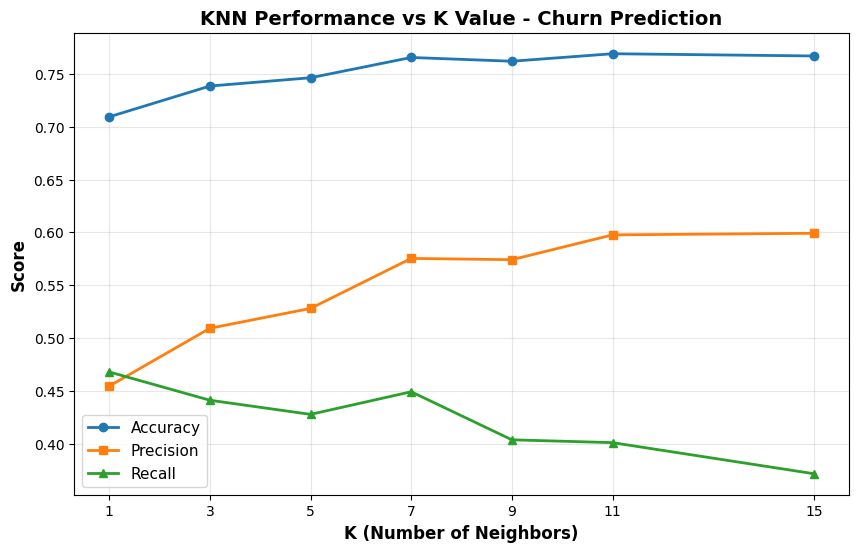

In [12]:
# Visualize
plt.figure(figsize=(10, 6))
plt.plot(results_df['K'], results_df['Accuracy'], marker='o', linewidth=2, label='Accuracy')
plt.plot(results_df['K'], results_df['Precision'], marker='s', linewidth=2, label='Precision')
plt.plot(results_df['K'], results_df['Recall'], marker='^', linewidth=2, label='Recall')
plt.xlabel('K (Number of Neighbors)', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('KNN Performance vs K Value - Churn Prediction', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(k_values)
plt.savefig('churn_knn_comparison.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved chart to 'churn_knn_comparison.png'")
plt.show()